In [1]:

HOMEPATH = "/home/ubuntu/fastai/"
DATA_HOME_DIR = HOMEPATH + "data/cifar-10/"
DATA_WORKING = DATA_HOME_DIR + "sample/"  #change this from + sample to DATA_HOME_DIR when production ready.
DATA_WORKING_RESULTS = DATA_WORKING + "results/"
TARGET_SIZE = (32,32)

print ("DATA_WORKING      :", DATA_WORKING)
print ("DATA_WORKING_RESULTS:", DATA_WORKING_RESULTS)

DATA_WORKING      : /home/ubuntu/fastai/data/cifar-10/sample/
DATA_WORKING_RESULTS: /home/ubuntu/fastai/data/cifar-10/sample/results/


In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image, sequence
import os
import numpy as np
import pandas as pd
import PIL
from PIL import Image

import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [3]:
batch_size = 64       #can increase this until memory error. also watch nvidia-smi to check memory use.
num_classes = 10      #can check this from data once loaded.
epochs = 3#100
num_predictions = 20

In [4]:
#path = HOMEPATH + "data/dogscats/sample/"
path = DATA_HOME_DIR 
#path = DATA_HOME_DIR + "sample/"
train_path = path + 'train/'
test_path = path + 'test/'
testUnknown_path = path + 'test/unknown/'
valid_path = path + 'valid/'
model_path = path + 'models/'
sample_path = path + 'sample/'
sampleTrain_path = path + 'sample/train/'
sampleTest_path = path + 'sample/test/'
sampleValid_path = path + 'sample/valid/'
sampleResults_path = path + 'sample/results/'
sampleTestUnknown_path = path + 'sample/test/unknown/'

categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]


In [6]:
dirList = [train_path, valid_path, sampleTrain_path, sampleValid_path]

for dir_path in dirList:
    for category in categories:
        print ("# of files in", dir_path+category, ":", len(dirFileList(dir_path+category)))

print ("# of files in", sampleTestUnknown_path, ":", len(dirFileList(sampleTestUnknown_path)))

# of files in /home/ubuntu/fastai/data/cifar-10/train/airplane : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/automobile : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/bird : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/cat : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/deer : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/dog : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/frog : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/horse : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/ship : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/train/truck : 4200
# of files in /home/ubuntu/fastai/data/cifar-10/valid/airplane : 800
# of files in /home/ubuntu/fastai/data/cifar-10/valid/automobile : 800
# of files in /home/ubuntu/fastai/data/cifar-10/valid/bird : 800
# of files in /home/ubuntu/fastai/data/cifar-10/valid/cat : 800
# of files in /home/ubuntu/fastai/data/cifar-10/valid/deer : 

In [7]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=TARGET_SIZE):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


In [8]:
def get_data(path, target_size=TARGET_SIZE):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.samples)])#nb: batches.samples required for python 3

In [9]:
print ("DATA_WORKING:", DATA_WORKING)
#nb: get_data is from utils.get_data
startTime= datetime.now()
print ("startTime:", startTime)

val_data = get_data(DATA_WORKING+'valid')

print ("val_data:", type(val_data), val_data.shape)

timeElapsed=datetime.now()-startTime
print('val_data:Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))


DATA_WORKING: /home/ubuntu/fastai/data/cifar-10/sample/
startTime: 2017-12-15 00:59:51.994497
Found 2000 images belonging to 10 classes.
val_data: <class 'numpy.ndarray'> (2000, 32, 32, 3)
val_data:Time elapsed (hh:mm:ss.ms) 0:00:00.605396


In [10]:
print ("DATA_WORKING:", DATA_WORKING)
startTime= datetime.now()
print ("startTime:", startTime)

trn_data = get_data(DATA_WORKING+'train')
print ("trn_data:", type(trn_data), trn_data.shape)

timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

DATA_WORKING: /home/ubuntu/fastai/data/cifar-10/sample/
startTime: 2017-12-15 00:59:52.953945
Found 8000 images belonging to 10 classes.
trn_data: <class 'numpy.ndarray'> (8000, 32, 32, 3)
Time elapsed (hh:mm:ss.ms) 0:00:07.111188


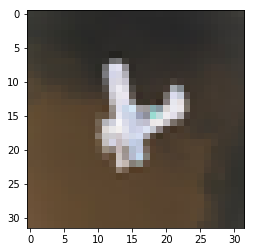

In [11]:
plt.imshow(trn_data[0])

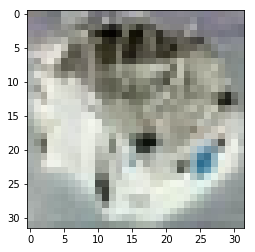

In [12]:
plt.imshow(trn_data[1311])

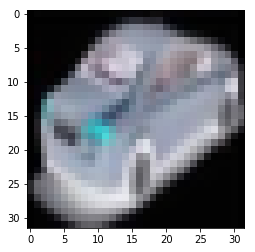

In [13]:
plt.imshow(trn_data[1312])

In [14]:
def makeLabels(n):
    #returns list of labels to match arrays loaded from images.
    labels = []
    #for category in categories:
    for i in range(0, len(categories)):
        #temp = [category]*n
        temp = [i]*n
        labels.append(temp)
        #print (len(labels), len(temp))
    labels = sum(labels, [])
    #print("len(labels):", len(labels))
    return labels

In [35]:
print (int(trn_data.shape[0]/10))
print (int(val_data.shape[0]/10))

800
200


In [36]:
#NB: this works only because the dataset has equal numbers in each category and categories order matches order files are loaded.
trn_labels = makeLabels(int(trn_data.shape[0]/10))#need to match number of items in trn_data
print("trn_labels:", len(trn_labels))
val_labels = makeLabels(int(val_data.shape[0]/10))
print("val_labels:", len(val_labels))


trn_labels: 8000
val_labels: 2000


In [37]:
for i in range(0, len(categories)):
    print (trn_labels[i*1312])

0
1
3
4
6
8
9


IndexError: list index out of range

In [38]:
#change trn_labels from list to numpy array with shape (len(trn_labels), 1) 
trn_labels = np.asarray(trn_labels).reshape((-1,1))
val_labels = np.asarray(val_labels).reshape((-1,1))

In [39]:
print ("trn_labels:", type(trn_labels), trn_labels.shape)
print ("val_labels:", type(val_labels), val_labels.shape)

trn_labels: <class 'numpy.ndarray'> (8000, 1)
val_labels: <class 'numpy.ndarray'> (2000, 1)


In [40]:
# Convert class vectors to binary class matrices.
trn_labels = keras.utils.to_categorical(trn_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
print ("trn_labels:", trn_labels.shape)
print ("val_labels:", val_labels.shape)

trn_labels: (8000, 10)
val_labels: (2000, 10)


In [41]:
trn_data.shape[1:]

(32, 32, 3)

In [42]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=trn_data.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [43]:
# initiate RMSprop optimizer
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.rmsprop(lr=0.001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [44]:
print ("# of uniques in trn_data:", len(np.unique(trn_data)))

# of uniques in trn_data: 256


In [45]:
#data loaded from images has integer values 0 to 255
#convert this to float values between 0.0 and 1.0
trn_data = trn_data.astype('float32')
val_data = val_data.astype('float32')
trn_data /= 255
val_data /= 255

In [46]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [47]:
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
print ("fitting:start")
startTime= datetime.now()
print ("startTime:", startTime)
datagen.fit(trn_data)
timeElapsed=datetime.now()-startTime
print('Time elapsed (hh:mm:ss.ms) {}'.format(timeElapsed))

fitting:start
startTime: 2017-12-15 01:14:35.039511
Time elapsed (hh:mm:ss.ms) 0:00:00.040240


In [48]:
print(trn_data.shape)
print(trn_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(8000, 32, 32, 3)
(8000, 10)
(2000, 32, 32, 3)
(2000, 10)


In [49]:
# Fit the model on the batches generated by datagen.flow().
history1 = model.fit_generator(datagen.flow(trn_data, trn_labels, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=len(trn_data) / batch_size,
                    validation_data=(val_data, val_labels),
                    workers=4)

Epoch 1/3
125/125 [==============================] - 9s - loss: 2.3034 - acc: 0.0930 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/3
125/125 [==============================] - 9s - loss: 2.3031 - acc: 0.0955 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/3
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0971 - val_loss: 2.3026 - val_acc: 0.1000


dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


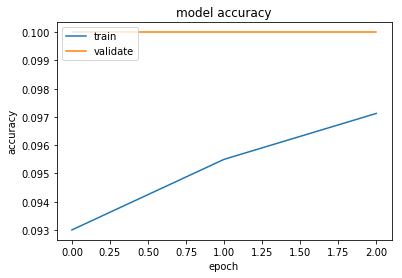

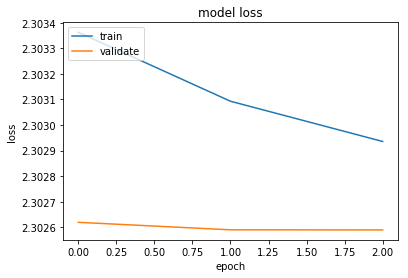

In [50]:
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [51]:
# Score trained model.
scores = model.evaluate(val_data, val_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1952/2000 [============================>.] - ETA: 0sTest loss: 2.30258966064
Test accuracy: 0.1


In [52]:
# Fit the model on the batches generated by datagen.flow().
history2 = model.fit_generator(datagen.flow(trn_data, trn_labels, batch_size=batch_size),
                    epochs=20,
                    steps_per_epoch=len(trn_data) / batch_size,
                    validation_data=(val_data, val_labels),
                    workers=4)

Epoch 1/20
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0961 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/20
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0949 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/20
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/20
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0914 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/20
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0996 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/20
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0963 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/20
125/125 [==============================] - 9s - loss: 2.3029 - acc: 0.0971 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/20
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0954 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 9/20
125/1

In [53]:
# Score trained model.
scores = model.evaluate(val_data, val_labels, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1824/2000 [==========================>...] - ETA: 0sTest loss: 2.3025874157
Test accuracy: 0.1


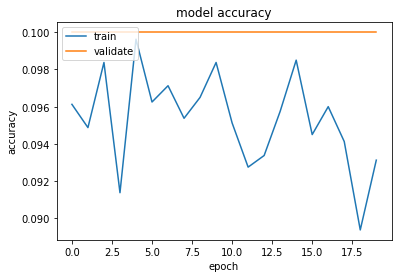

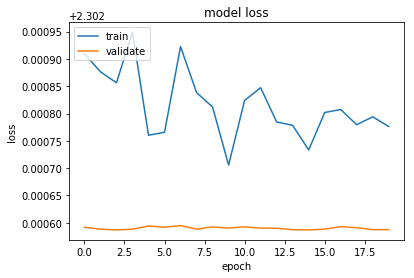

In [54]:
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [55]:
# Fit the model on the batches generated by datagen.flow().
history3 = model.fit_generator(datagen.flow(trn_data, trn_labels, batch_size=batch_size),
                    epochs=10,
                    steps_per_epoch=len(trn_data) / batch_size,
                    validation_data=(val_data, val_labels),
                    workers=4)

Epoch 1/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0949 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
125/125 [==============================] - 9s - loss: 2.3027 - acc: 0.0930 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0926 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0921 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0944 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0973 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/10
125/125 [==============================] - 9s - loss: 2.3028 - acc: 0.0907 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 9/10
125/1

In [56]:
from keras.models import load_model
model.save_weights('history3_weights.h5')

In [57]:
# save as JSON
json_string = model.to_json()
import json
with open('CIFAR-10-cnn_custom_python3-model.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [58]:
model.save('history3.h5')

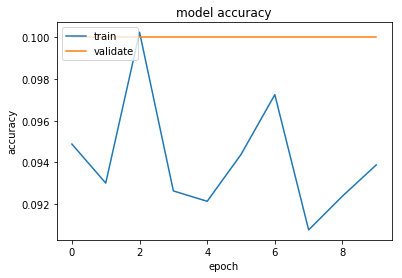

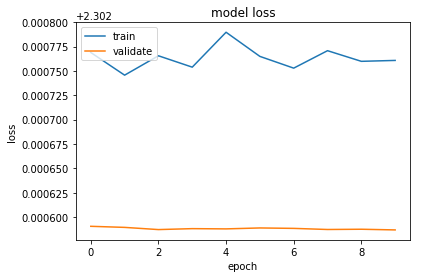

In [59]:
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
#we see the accuracy and loss have stopped improving - adjust learning rate.

In [60]:
#probably not best method. save weights, recompile model with new learning rate, reload weights.
#need to look at self tuning of learning rates.

In [61]:
opt = keras.optimizers.rmsprop(lr=0.0001)#decrease learning rate (was 0.001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [62]:
model.load_weights('history3_weights.h5')

In [65]:
history4 = model.fit_generator(datagen.flow(trn_data, trn_labels, batch_size=batch_size),
                    epochs=10,
                    steps_per_epoch=len(trn_data) / batch_size,
                    validation_data=(val_data, val_labels),
                    workers=4)

Epoch 1/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0994 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1005 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0996 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/10
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 9/10
125/1

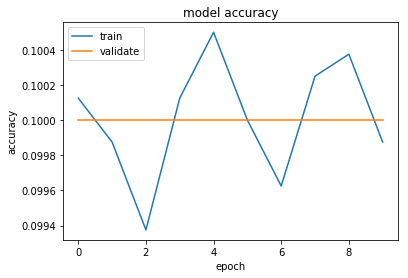

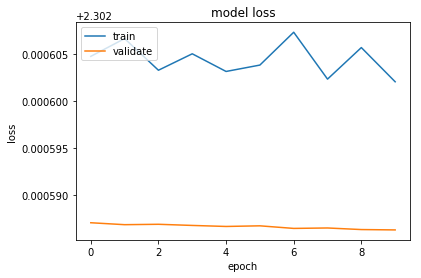

In [66]:
history = history4
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()


In [67]:
history5 = model.fit_generator(datagen.flow(trn_data, trn_labels, batch_size=batch_size),
                    epochs=50,
                    steps_per_epoch=len(trn_data) / batch_size,
                    validation_data=(val_data, val_labels),
                    workers=4)

Epoch 1/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1004 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 5/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0994 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1005 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.1000 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 8/50
125/125 [==============================] - 9s - loss: 2.3026 - acc: 0.0999 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 9/50
125/1

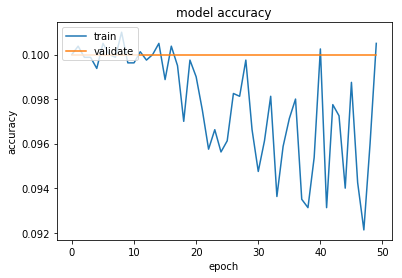

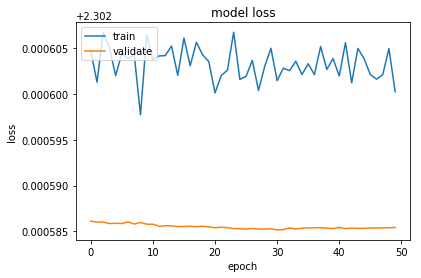

In [68]:
history = history5
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
#obviously wrong: validate accuracy is not moving, train accuracy is decreasing and oscillating.
#obviously wrong: losses are not converging